In [ ]:
# %%

# # Test Calibrate
#
# Run Calibrate and do exploratory analysis of the results.
# 

In [ ]:
# %%

import os
import pyciemss
import torch
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl
# from typing import Dict, List, Callable

import pyciemss.visuals.plots as plots
import pyciemss.visuals.vega as vega
import pyciemss.visuals.trajectories as trajectories

from pyciemss.integration_utils.observation import load_data

from pyciemss.integration_utils.intervention_builder import (
    param_value_objective,
    start_time_objective,
)

In [ ]:
# %%

# Models and datasets
MODEL_PATH = "https://raw.githubusercontent.com/DARPA-ASKEM/simulation-integration/main/data/models/"
DATA_PATH = "https://raw.githubusercontent.com/DARPA-ASKEM/simulation-integration/main/data/datasets/"

model1 = os.path.join(MODEL_PATH, "SEIRHD_NPI_Type1_petrinet.json")
model2 = os.path.join(MODEL_PATH, "SEIRHD_NPI_Type2_petrinet.json")
model3 = os.path.join(MODEL_PATH, "SIR_stockflow.json")

dataset1 = os.path.join(DATA_PATH, "SIR_data_case_hosp.csv")
dataset2 = os.path.join(DATA_PATH, "traditional.csv")

d = load_data(dataset1)
d = {"timepoint": d[0]} | d[1]
d = {k: v.numpy() for k, v in d.items()}
dataset1_df = pd.DataFrame(d)

Data printout: This dataset contains 2 rows of data. The first column, Timestamp, begins at 1.1 and ends at 3.3. The subsequent columns are named: case, hosp


In [ ]:
# %%

# Settings

start_time = 0.0
end_time = 5.0
logging_step_size = 0.1
num_samples = 100

In [ ]:
# %%

# Run pre-calibration Simulate

result_precalibrate = pyciemss.sample(model1, end_time, logging_step_size, num_samples, start_time=start_time)

result_precalibrate["data"].head()

,timepoint_id,sample_id,timepoint_unknown,persistent_beta_c_param,persistent_kappa_param,persistent_gamma_param,persistent_hosp_param,persistent_death_hosp_param,persistent_I0_param,S_state,I_state,E_state,R_state,H_state,D_state,infected_observable_state,exposed_observable_state,hospitalized_observable_state,dead_observable_state
0,0,0,0.0,0.668201,0.090259,0.189744,0.125675,0.074236,9.956974,19339990.0,9.956974,40.000000,0.000000,0.000000,0.000000,9.956974,40.000000,0.000000,0.000000
1,1,0,0.1,0.668201,0.090259,0.189744,0.125675,0.074236,9.956974,19339990.0,10.749218,39.104698,0.172031,0.024453,0.000018,10.749218,39.104698,0.024453,0.000018
2,2,0,0.2,0.668201,0.090259,0.189744,0.125675,0.074236,9.956974,19339990.0,11.504749,38.238480,0.357365,0.050249,0.000073,11.504749,38.238480,0.050249,0.000073
3,3,0,0.3,0.668201,0.090259,0.189744,0.125675,0.074236,9.956974,19339990.0,12.225016,37.400135,0.555427,0.077276,0.000168,12.225016,37.400135,0.077276,0.000168
4,4,0,0.4,0.668201,0.090259,0.189744,0.125675,0.074236,9.956974,19339990.0,12.911289,36.588806,0.765665,0.105427,0.000303,12.911289,36.588806,0.105427,0.000303


In [ ]:
# %%

# Run Calibrate

data_mapping = {"case": "infected", "hosp": "hospitalized"} # data is mapped to observables
# data_mapping = {"case": "I", "hosp": "H"} # data is mapped to state variables

num_iterations = 10

result_calibrate = pyciemss.calibrate(
    model1, 
    dataset1, 
    data_mapping = data_mapping, 
    num_iterations = num_iterations
)

Data printout: This dataset contains 2 rows of data. The first column, Timestamp, begins at 1.1 and ends at 3.3. The subsequent columns are named: case, hosp


In [ ]:
# %%

result_calibrate

# result_calibrate = {
#     "inferred_parameters": AutoGuideList((0): AutoDelta(), (1): AutoLowRankMultivariateNormal())
#     "loss": <float>y
# }

{'inferred_parameters': AutoGuideList(
   (0): AutoDelta()
   (1): AutoLowRankMultivariateNormal()
 ),
 'loss': 41.429322719573975}

In [ ]:
# %%

parameter_estimates = result_calibrate["inferred_parameters"]
parameter_estimates()

# parameter_estimates() = {
#     'persistent_beta_c': tensor(0.4848, grad_fn=<ExpandBackward0>),
#     'persistent_kappa': tensor(0.4330, grad_fn=<ExpandBackward0>),
#     'persistent_gamma': tensor(0.3387, grad_fn=<ExpandBackward0>),
#     'persistent_hosp': tensor(0.0777, grad_fn=<ExpandBackward0>),
#     'persistent_death_hosp': tensor(0.0567, grad_fn=<ExpandBackward0>),
#     'persistent_I0': tensor(9.1598, grad_fn=<ExpandBackward0>)
# }

{'persistent_beta_c': tensor(0.4833, grad_fn=<ExpandBackward0>),
 'persistent_kappa': tensor(0.2492, grad_fn=<ExpandBackward0>),
 'persistent_gamma': tensor(0.2948, grad_fn=<ExpandBackward0>),
 'persistent_hosp': tensor(0.1559, grad_fn=<ExpandBackward0>),
 'persistent_death_hosp': tensor(0.0517, grad_fn=<ExpandBackward0>),
 'persistent_I0': tensor(7.3117, grad_fn=<ExpandBackward0>)}

In [ ]:
# %%

# Run post-calibration Simulate
result_postcalibrate = pyciemss.sample(
    model1, 
    end_time, 
    logging_step_size, 
    num_samples,
    start_time = start_time, 
    inferred_parameters = result_calibrate["inferred_parameters"]
)

result_postcalibrate["data"].head()

,timepoint_id,sample_id,timepoint_unknown,persistent_beta_c_param,persistent_kappa_param,persistent_gamma_param,persistent_hosp_param,persistent_death_hosp_param,persistent_I0_param,S_state,I_state,E_state,R_state,H_state,D_state,infected_observable_state,exposed_observable_state,hospitalized_observable_state,dead_observable_state
0,0,0,0.0,0.433666,0.275358,0.258855,0.162637,0.06154,7.358702,19339992.0,7.358702,40.000000,0.000000,0.000000,0.000000,7.358702,40.000000,0.000000,0.000000
1,1,0,0.1,0.433666,0.275358,0.258855,0.162637,0.06154,7.358702,19339992.0,8.148121,39.223381,0.168431,0.032337,0.000020,8.148121,39.223381,0.032337,0.000020
2,2,0,0.2,0.433666,0.275358,0.258855,0.162637,0.06154,7.358702,19339992.0,8.898700,38.486855,0.354180,0.067241,0.000081,8.898700,38.486855,0.067241,0.000081
3,3,0,0.3,0.433666,0.275358,0.258855,0.162637,0.06154,7.358702,19339992.0,9.612405,37.788448,0.556473,0.104506,0.000186,9.612405,37.788448,0.104506,0.000186
4,4,0,0.4,0.433666,0.275358,0.258855,0.162637,0.06154,7.358702,19339992.0,10.291086,37.126183,0.774573,0.143933,0.000339,10.291086,37.126183,0.143933,0.000339


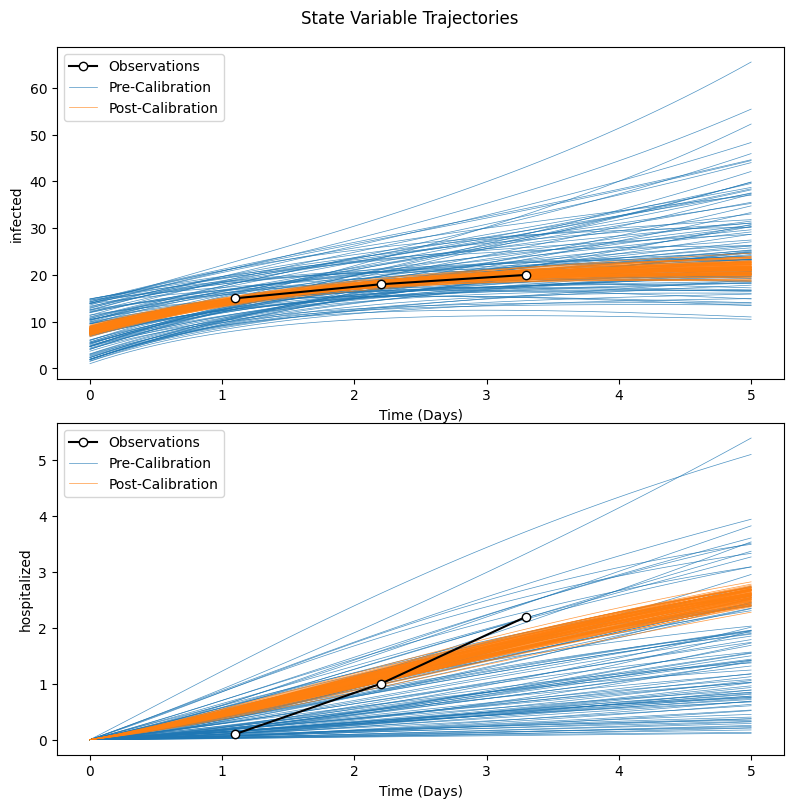

In [ ]:
# %%

# Plot trajectories

cmap = mpl.colormaps["tab10"](range(10))
fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (8, 8))
fig.suptitle("State Variable Trajectories")
fig.tight_layout()

for ax, (train_data_state, model_state) in zip(axes, data_mapping.items()):

    # Pre-/post-calibrate trajectories
    for result_, label, color in zip((result_precalibrate, result_postcalibrate), ("Pre-Calibration", "Post-Calibration"), (cmap[0, :], cmap[1, :])):

        x = result_["data"][result_["data"]["sample_id"] == 0]["timepoint_unknown"]
        for i in range(num_samples):
            result = result_["data"][result_["data"]["sample_id"] == i]
            
            if "_".join([model_state, "state"]) in result.columns:
                l = "_".join([model_state, "state"])
                y = result[l]
            elif "_".join([model_state, "observable", "state"]) in result.columns:
                l = "_".join([model_state, "observable", "state"])
                y = result[l]
            else:
                l = None
                y = None
            
            if ~isinstance(y, type(None)):
                ax.plot(x, y, linewidth = 0.5, color = color, alpha = 0.8, label = label)


    # Training dataset trajectories
    ax.plot(dataset1_df["timepoint"], dataset1_df[train_data_state], marker = "o", color = "black", markeredgecolor = "black", markerfacecolor= "white", label = train_data_state)      
    
    # Axis labels
    __ = plt.setp(ax, xlabel = "Time (Days)", ylabel = model_state)

    # Legend
    l = [
        mpl.lines.Line2D([0], [0], label = "Observations", marker = "o", color = "black", markeredgecolor = "black", markerfacecolor= "white"),
        mpl.lines.Line2D([0], [0], label = "Pre-Calibration", linewidth = 0.5, color = cmap[0, :], alpha = 0.8),
        mpl.lines.Line2D([0], [0], label = "Post-Calibration", linewidth = 0.5, color = cmap[1, :], alpha = 0.8)
    ]
    __ = ax.legend(handles = l)


fig.savefig("./figures/test_calibrate_interface_state_trajectories.png")

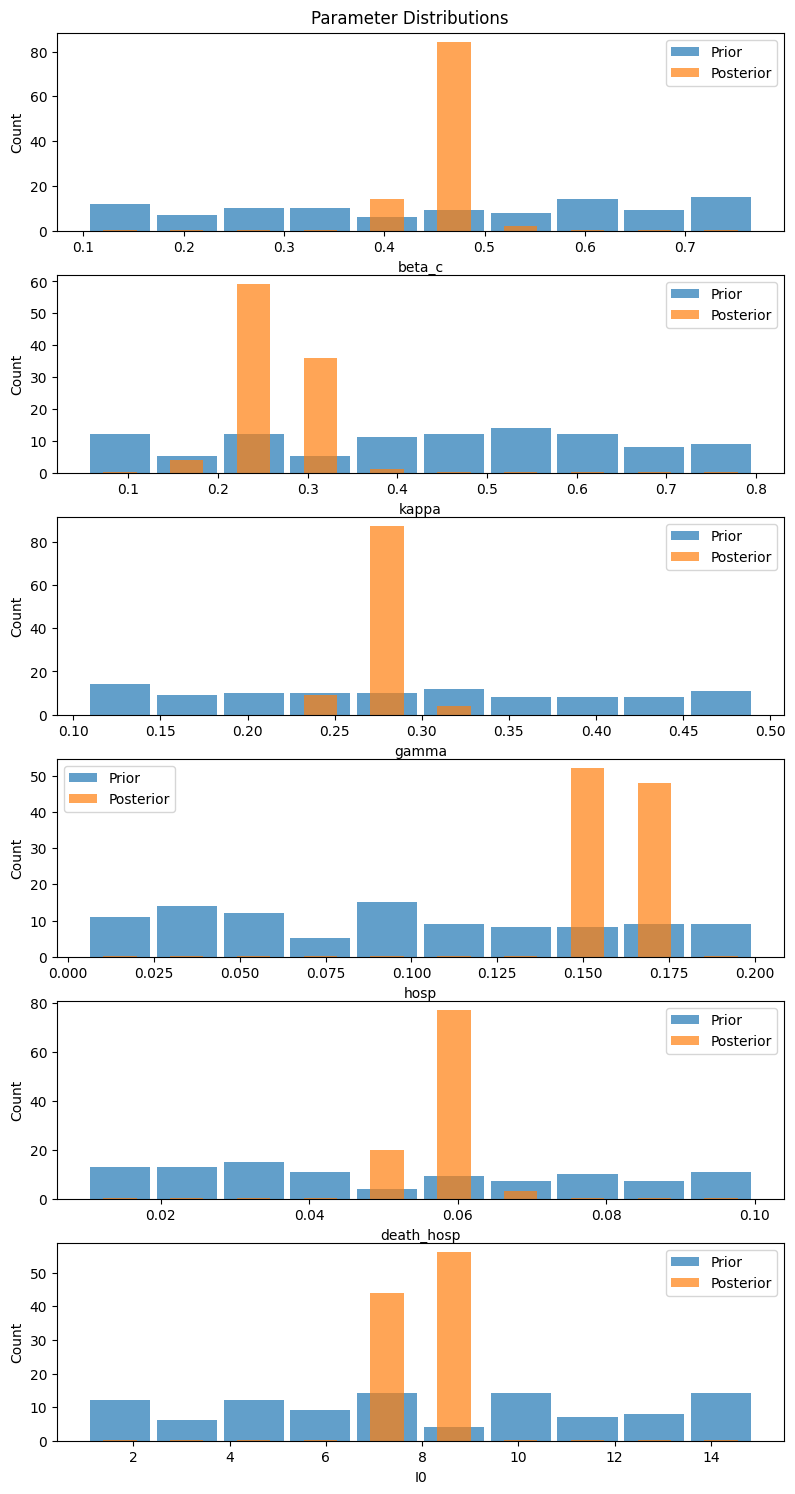

In [ ]:
# %%

# Plot parameter distributions

parameters = list(parameter_estimates().keys())
num_parameters = len(parameters)

fig, axes = plt.subplots(nrows = num_parameters, ncols = 1, figsize = (8, 15))
fig.suptitle("Parameter Distributions")
fig.tight_layout()

for ax, p in zip(axes, parameters):
    

    # Pre-/post-calibrate trajectories
    for i, (result_, label, color) in enumerate(zip((result_precalibrate, result_postcalibrate), ("Prior", "Posterior"), (cmap[0, :], cmap[1, :]))):

        result = result_["data"][result_["data"]["timepoint_id"] == 0]
        samples = result[p + "_param"]
        

        if i == 0:
            h, b = np.histogram(samples, density = False)
            w = b[1] - b[0]
        else:
            h, b = np.histogram(samples, density = False, bins = b)


        x = 0.5 * (b[1:] + b[0:-1])
        if i == 0:
            __ = ax.bar(x, h + 0.1, width = 0.9 * w, align = "center", label = label, alpha = 0.7)
        else:
            __ = ax.bar(x, h + 0.1, width = 0.5 * w, align = "center", label = label, alpha = 0.7)


    # Legend
    l = [
        mpl.patches.Patch(facecolor = cmap[0, :], alpha = 0.7, label = "Prior"),
        mpl.patches.Patch(facecolor = cmap[1, :], alpha = 0.7, label = "Posterior"),
    ]
    __ = ax.legend(handles = l)

    # Axis labels
    xlabel = "_".join(p.split("_")[1:])
    __ = plt.setp(ax, xlabel = xlabel, ylabel = "Count")


fig.savefig("./figures/test_calibrate_interface_parameter_distributions.png")